In [1846]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.optimize import fsolve
from scipy.constants import N_A
import matplotlib.pyplot as plt
import seaborn as sns
import math

In [1847]:
Target_cell_number = 2e5
E_T_ratio = 20
well_size = 150e-6
sigma = well_size*N_A/Target_cell_number
synapse_gap = 25e-9
synapse_width = 10e-6
tumour_cell_radius = 8e-6
tumour_cell_surface_area = 4*math.pi*((tumour_cell_radius)**2)
tumour_cell_IS_proportion = (synapse_width**2)/(tumour_cell_surface_area)
NK_cell_radius = 3.25e-6
NK_cell_surface_area = 4*math.pi*((NK_cell_radius)**2)
NK_cell_IS_proportion = (synapse_width**2)/NK_cell_surface_area
assay_to_synapse_conversion = (synapse_width**2*synapse_gap)/well_size
sigma_synapse = sigma*assay_to_synapse_conversion
synapse_area = synapse_width**2

In [1848]:
# Tumour cell opsonization

"""
def A2_steady_state(A1_hat, rtot, K2):
    rtot_hat = rtot*K2
    A2_hat = A1_hat*(rtot_hat - A1_hat)/(2*(1+A1_hat))

    return A2_hat/K2

def A1_steady_state(x, rtot, Atot, K2, K1):
    rtot_hat = rtot*K2
    Ainit_hat = Atot*K2
    K21 = K2/K1

    f0 = 2*Ainit_hat*rtot_hat
    f1 = rtot_hat*(2*(Ainit_hat-1) - rtot_hat) - 2*Ainit_hat - K21
    f2 = 2*(1-Ainit_hat-K21)
    f3 = 1-K21
    
    poly = f3*(x**3) + f2*(x**2) + f1*x + f0

    return poly
"""

'\ndef A2_steady_state(A1_hat, rtot, K2):\n    rtot_hat = rtot*K2\n    A2_hat = A1_hat*(rtot_hat - A1_hat)/(2*(1+A1_hat))\n\n    return A2_hat/K2\n\ndef A1_steady_state(x, rtot, Atot, K2, K1):\n    rtot_hat = rtot*K2\n    Ainit_hat = Atot*K2\n    K21 = K2/K1\n\n    f0 = 2*Ainit_hat*rtot_hat\n    f1 = rtot_hat*(2*(Ainit_hat-1) - rtot_hat) - 2*Ainit_hat - K21\n    f2 = 2*(1-Ainit_hat-K21)\n    f3 = 1-K21\n    \n    poly = f3*(x**3) + f2*(x**2) + f1*x + f0\n\n    return poly\n'

In [1849]:
def A1_steady_state(x, Atot, k1, koff, k2, rtot):
    express = 2*k1*(rtot - x - 2*(k2*x*(rtot-x)/(2*(koff + k2*x))))*(Atot - x - (k2*x*(rtot-x)/(2*(koff + k2*x)))) -koff*x - k2*x*(rtot - x - 2*(k2*x*(rtot-x)/(2*(koff + k2*x)))) +2*koff*(k2*x*(rtot-x)/(2*(koff + k2*x)))

    return express

def A2_steady_state(x, k2, koff, rtot):
    express = k2*x*(rtot-x)/(2*(koff + k2*x))

    return express

In [1850]:
#Effector cell opsonization

def effector_A1(ftot, Atot, Q_D):

    a = 1
    b = -(ftot + Atot + Q_D)
    c = ftot*Atot

    return (-b - np.sqrt(b**2 - 4*a*c))/(2*a)

In [1851]:
kon = 1e5
qon = 6.5e3
koff = 1e-4
qoff = 4.7e-3
rtot = 1e5
ftot= 2.2e5
D = 1e-14
D_f = 7.4e-14
k2 = 4*D/tumour_cell_surface_area
k1 = kon/sigma
K2 = k2/koff
K1 = k1/koff
q1 = qon/sigma
Q_D = qoff/q1
A0s = np.geomspace(1e-12, 1e-4, 75)

k6 = 2*(D +D_f)/(synapse_area)  
k7 = 2*D/synapse_area
print((k1/k2))
print(k6/k7)
frac = ((k6/k7)/(k1/k2))

4.4516158587154815e-06
8.4


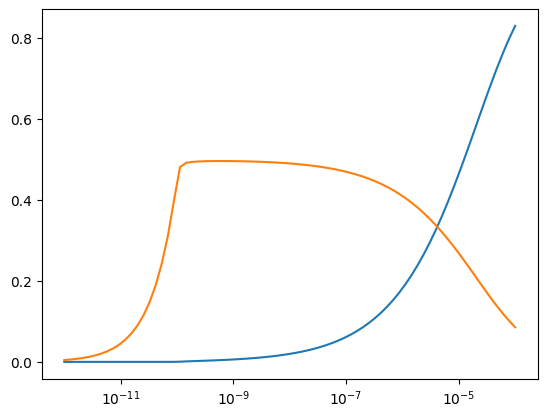

In [1852]:
# Simulate Target cell opsonsation

A1_array = np.zeros_like(A0s)
A2_array = np.zeros_like(A0s)


for i, Ainit in enumerate(A0s):

    Atot = Ainit*sigma
    
    A1_st_sin = fsolve(A1_steady_state, [1e-2], args=(Atot, k1, koff, k2, rtot))
    A2_st_sin = A2_steady_state(A1_st_sin, k2, koff, rtot)

    A1_array[i] = A1_st_sin
    A2_array[i] = A2_st_sin


plt.semilogx(A0s, A1_array/rtot)
plt.semilogx(A0s, A2_array/rtot)

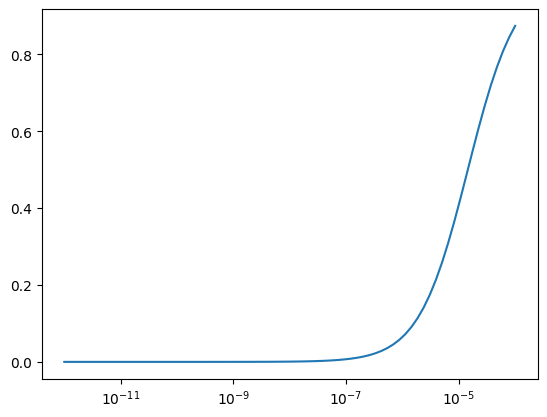

In [1853]:
#Simulate Effector cell opsonization

A1_effector_array = np.zeros_like(A0s)

for i, Ainit in enumerate(A0s):

    Atot = Ainit*sigma
    Atot = Atot - A1_array[i] - A2_array[i]
    Atot = Atot/E_T_ratio
    A1_E_stst = effector_A1(ftot, Atot, Q_D)
    A1_effector_array[i] = A1_E_stst

plt.semilogx(A0s, A1_effector_array/ftot)

In [1854]:
#Effector cell binding within synapse
ratio_f = np.zeros_like(A0s)
A01_approx = np.zeros_like(A0s)
A11_approx = np.zeros_like(A0s)
A21_approx = np.zeros_like(A0s)
fc_crosslinks = np.zeros_like(A0s)
rtot_synapse = rtot*tumour_cell_IS_proportion
A1_pre_synapse = A1_array*tumour_cell_IS_proportion
A2_pre_synapse = A2_array*tumour_cell_IS_proportion
A1_E_pre_synapse = A1_effector_array*NK_cell_IS_proportion
ftot_synapse = ftot*NK_cell_IS_proportion
rf_sim = np.zeros_like(A0s)
Atots_approx = np.zeros_like(A0s)
sol_guess = np.zeros_like(A0s)
sol_guess2 = np.zeros_like(A0s)
A10_approx = np.zeros_like(A0s)
A20_approx = np.zeros_like(A0s)
for i in range(len(A1_E_pre_synapse)):

    ftot_bar = ftot_synapse - A1_E_pre_synapse[i]
    Atot_bar = A1_pre_synapse[i] + A2_pre_synapse[i]
    Atots_approx[i] += Atot_bar
    ratio_f[i] = Atot_bar/ftot_bar
    q1_bar = 2*(D+D_f)/synapse_area
    Q_D_bar = qoff/q1_bar
    A1_synapse = effector_A1(ftot_bar, Atot_bar, Q_D_bar)
    #sol_guess[i] += A1_synapse
    sol_guess2[i] += A1_synapse
    A11_prop = A1_pre_synapse[i]/(A1_pre_synapse[i] + A2_pre_synapse[i])
    A21_prop = A2_pre_synapse[i]/(A1_pre_synapse[i] + A2_pre_synapse[i])
    A11_approx[i] += A11_prop*A1_synapse
    A21_approx[i] += A1_synapse*A21_prop
    A10_approx[i] += (A1_pre_synapse[i] - A11_approx[i])
    A20_approx[i] += (A2_pre_synapse[i] - A21_approx[i])

    sol_guess[i] += A11_approx[i] + 2*A21_approx[i]
    A01_approx[i] += A1_E_pre_synapse[i]
    rf_sim[i] = ftot_synapse - A1_synapse - A1_E_pre_synapse[i]
    fc_crosslinks[i] += A1_synapse

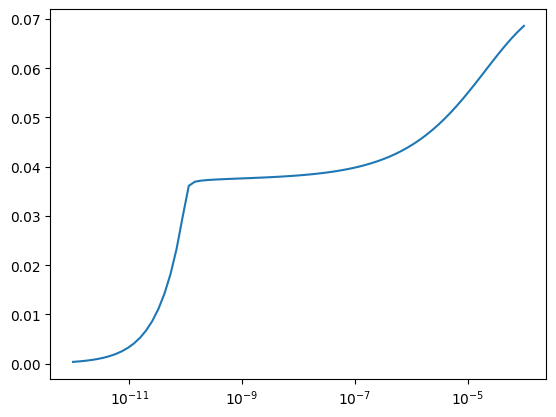

In [1855]:
plt.semilogx(A0s, fc_crosslinks/ftot_synapse)

In [1856]:
#Target cell binding within synapse

holder = np.zeros_like(A0s)
rt_sim = np.zeros_like(A0s)
ratio_t = np.zeros_like(A0s)
for i in range(len(A1_E_pre_synapse)):
    
    rtot_bar = rtot_synapse - A1_pre_synapse[i] - 2*A2_pre_synapse[i]
    Atot_bar = A1_E_pre_synapse[i]
    Atots_approx[i] += Atot_bar
    ratio_t[i] = Atot_bar/rtot_bar
  
    k1_bar = 2*(D + D_f)/synapse_area
    k2_bar = 2*D/synapse_area
    A1_st = fsolve(A1_steady_state, [1e-3], args=(Atot_bar, k1_bar, koff, k2_bar, rtot_bar))
    A2_st = A2_steady_state(A1_st, k2_bar, koff, rtot_bar)
    sol_guess[i] += A1_st + 2*A2_st
    A11_approx[i] += A1_st
    A21_approx[i] += A2_st
    A01_approx[i] +- A1_st + A2_st
    rt_sim[i] = rtot_synapse - A1_st -2*A2_st - A1_pre_synapse[i] - 2*A2_pre_synapse[i]
    holder[i] = (A1_st + 2*A2_st)/rtot_bar
    fc_crosslinks[i] += (A1_st + A2_st)

8.4
[0.02952188] 0.0009480840870281781
[0.02955368] 0.0012161756676221103
[0.02958177] 0.0015601180449777985
[0.02960671] 0.0020013986538032214
[0.02962898] 0.0025676095817459554
[0.02964899] 0.0032941930990659785
[0.02966714] 0.004226693757090061
[0.02968379] 0.00542366855313503
[0.02969928] 0.006960454979036967
[0.02971395] 0.008934062902085316
[0.0297282] 0.011469545674572146
[0.02974248] 0.014728331568107933
[0.0297574] 0.01891917313560043
[0.02977388] 0.024312622263096273
[0.02979346] 0.031260291309536115
[0.02981916] 0.04022061621844841
[0.02985801] 0.051793117790111864
[0.02993155] 0.06676009788816373
[0.03015389] 0.08606667575350002
[0.03229079] 0.10467365332806366
[0.03604579] 0.107029679344123
[0.0394227] 0.10755296508796164
[0.0430232] 0.10779258310230944
[0.04715415] 0.10792520884933765
[0.05209896] 0.10800135552835854
[0.0581999] 0.10804125588219904
[0.06591757] 0.10805450714997278
[0.07591008] 0.1080460591474548
[0.08919096] 0.10801850214829756
[0.10781642] 0.107973079642

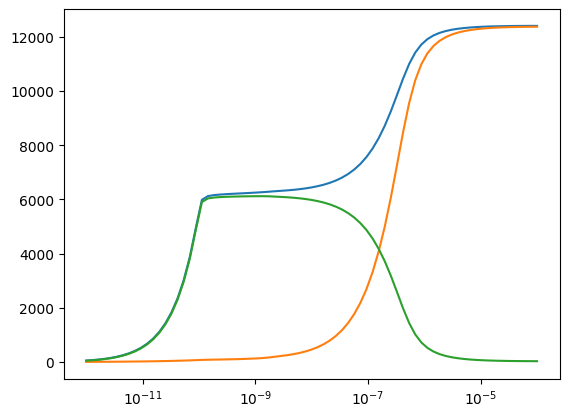

In [1857]:
crosslinks_guess = np.zeros_like(A0s)
q1_bar = 2*(D+D_f)/synapse_area
Q_D_bar = qoff/q1_bar
A11_approx1 = np.zeros_like(A0s)
A21_approx1 = np.zeros_like(A0s)
k3 = qon/sigma_synapse
k22 = 4*D/synapse_area
k6 = 2*(D +D_f)/(synapse_area)  
k7 = 2*D/synapse_area
print(k6/k7)
for i in range(len(A0s)):
    A1_E_stst = effector_A1(A01_approx[i] , A01_approx[i] , Q_D_bar)
    A1_st1 = fsolve(A1_steady_state, [1e-2], args=((fc_crosslinks[i] + A1_E_stst) , k6, koff, k7, sol_guess[i]))
    A2_st1 = A2_steady_state(A1_st1, k7, koff, sol_guess[i])
    #A1_E_stst = A01_approx[i]
    #A1_st2 = fsolve(A1_steady_state, [1e-2], args=(A10_approx[i] + A20_approx[i] , k3, koff, k22, A10_approx[i] + 2*A20_approx[i]))
    #A2_st2 = A2_steady_state(A1_st2, k22, koff, A10_approx[i] + 2*A20_approx[i])

    #A1_st3 = fsolve(A1_steady_state, [1e-2], args=((fc_crosslinks[i] + A1_E_stst) , k6, koff, k7, sol_guess[i] + (A10_approx[i] + 2*A20_approx[i] - (A1_st2 + 2*A2_st2))))
    #A2_st3 = A2_steady_state(A1_st1, k7, koff, sol_guess[i] + (A10_approx[i] + 2*A20_approx[i] - (A1_st2 + 2*A2_st2)))
    #A1_st3 = fsolve(A1_steady_state, [1e-2], args=(A1_st1 + A2_st1 + (A1_E_stst - (A1_st1 + A2_st1 - fc_crosslinks[i])) , k6, koff, k7, A1_st1 + 2*A2_st1 + (A1_st2 - A10_approx[i])))
    #A2_st3 = A2_steady_state(A1_st3, k7, koff, A1_st1 + 2*A2_st1 + (A1_st2 - A10_approx[i]))
    A_ratio = A20_approx[i]/(A10_approx[i] +A20_approx[i])
    correction = np.min([A1_E_stst - (A1_st1 + A2_st1 - fc_crosslinks[i]) , A20_approx[i]])
    #correction = np.min([A1_E_stst - (A1_st1 + A2_st1 - fc_crosslinks[i]), A10_approx[i] + A20_approx[i]])
    print(A1_E_stst - (A1_st1 + A2_st1 - fc_crosslinks[i]), A20_approx[i])
    A_ratio = A10_approx[i]/A20_approx[i]

    A11_approx1[i] = A1_st1 + correction
    A21_approx1[i] = A2_st1
    
    crosslinks_guess[i] = A1_st1 + A2_st1 + correction
    A01_approx[i] = A1_E_stst - (crosslinks_guess[i] - fc_crosslinks[i])


plt.semilogx(A0s, crosslinks_guess)
plt.semilogx(A0s, A11_approx1)
plt.semilogx(A0s, A21_approx1)

In [1858]:
def S_two_cells(t, z, k1, k2, k3, k4, k5, k6, k7, k1off, k2off, rtot_synapse, ftot_synapse, Atot):


    A0 = (Atot - (z[0] + z[1] + z[3] + z[4] + z[2]))
    rt = rtot_synapse- z[0] - z[3] - 2*(z[1] + z[4])
    rf = ftot_synapse - z[2] - (z[3] + z[4])
    
    dA10 =   2*k1*(A0)*(rt) - k1off*z[0] - k2*1*z[0]*(rt) + 2*k1off*z[1] - k4*z[0]*(rf) + k2off*z[3]
    dA20 = k2*1*z[0]*(rt) - 2*k1off*z[1] - k5*z[1]*(rf) + k2off*z[4]
    dA01 =  k3*(A0)*(rf) - k2off*z[2] - 2*1*k6*z[2]*(rt) + k1off*z[3]
    dA11 = k4*z[0]*(rf) - k2off*z[3] + 2*1*k6*z[2]*(rt) - k1off*z[3] - 1*k7*z[3]*(rt) + 2*1*k1off*z[4]
    dA21 = k5*z[1]*(rf) - k2off*z[4] + 1*k7*z[3]*(rt) - 2*k1off*1*z[4]
    dz = [dA10, dA20, dA01, dA11, dA21]

    return dz

In [1859]:
k1 = kon/sigma_synapse
k3 = qon/sigma_synapse
k2 = 4*D/(synapse_area)
k4 = 2*(D +D_f)/(synapse_area)   
k5 = 2*(D +D_f)/(synapse_area)  
k6 = 2*(D +D_f)/(synapse_area)  
k7 = 2*D/synapse_area

t_end = 60*60*1000
t = np.geomspace(1e-10, t_end, 1000)
tspan = [1e-10, t_end]
fc_sim_array = np.zeros_like(A0s)
rt_array = np.zeros_like(A0s)
rf_array = np.zeros_like(A0s)
A11_array = np.zeros_like(A0s)
A21_array = np.zeros_like(A0s)
A00_array = np.zeros_like(A0s)
A01_array = np.zeros_like(A0s)
Atots_sim = np.zeros_like(A0s)
A10_array = np.zeros_like(A0s)
A20_array = np.zeros_like(A0s)

for i, A0 in enumerate(A0s):
    Atot = A1_pre_synapse[i] + A2_pre_synapse[i] + A1_E_pre_synapse[i]
    Atots_sim[i] = Atot
    z0 = [A1_pre_synapse[i], A2_pre_synapse[i], A1_E_pre_synapse[i], 0, 0]
    
    z = solve_ivp(S_two_cells, tspan, z0, method='BDF', atol=1e-5, rtol=1e-5,  t_eval=t, args=(k1, k2, k3, k4, k5, k6, k7, koff, qoff, rtot_synapse, ftot_synapse, Atot))
    print(i, z.message)
    A10 = z.y[0]
    A20 = z.y[1]
    A01 = z.y[2]
    A11 = z.y[3]
    A21 = z.y[4]
    rt = rtot_synapse - A10 - A11 - 2*(A20 + A21)
    rf = ftot_synapse - A01 - (A11 + A21)
    fc_sim_array[i] = A11[-1] + A21[-1]

    A11_array[i] = A11[-1]
    A21_array[i] = A21[-1]
    A10_array[i] = A10[-1]
    A20_array[i] = A20[-1]
    rt_array[i] = rt[-1]
    rf_array[i] = rf[-1]
    A01_array[i] = A01[-1]
    A00_array[i] = (Atot - A10[-1] - A20[-1] - A01[-1] - A11[-1] - A21[-1])

0 The solver successfully reached the end of the integration interval.
1 The solver successfully reached the end of the integration interval.
2 The solver successfully reached the end of the integration interval.
3 The solver successfully reached the end of the integration interval.
4 The solver successfully reached the end of the integration interval.
5 The solver successfully reached the end of the integration interval.


6 The solver successfully reached the end of the integration interval.
7 The solver successfully reached the end of the integration interval.
8 The solver successfully reached the end of the integration interval.
9 The solver successfully reached the end of the integration interval.
10 The solver successfully reached the end of the integration interval.
11 The solver successfully reached the end of the integration interval.
12 The solver successfully reached the end of the integration interval.
13 The solver successfully reached the end of the integration interval.
14 The solver successfully reached the end of the integration interval.
15 The solver successfully reached the end of the integration interval.
16 The solver successfully reached the end of the integration interval.
17 The solver successfully reached the end of the integration interval.
18 The solver successfully reached the end of the integration interval.
19 The solver successfully reached the end of the integration interv

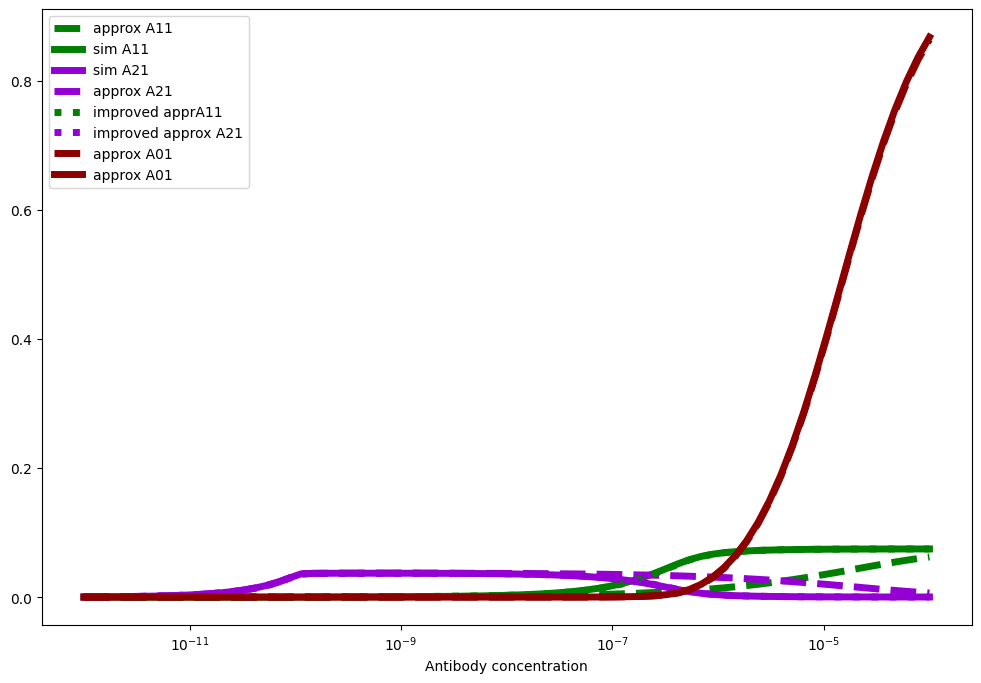

In [1860]:

fig, ax = plt.subplots(figsize=(12, 8))
#ax.semilogx(A0s, rt_array/rtot_synapse, label='free target',lw=5, color='blue')
#ax.semilogx(A0s, rf_array/ftot_synapse, label=' free fc', lw=5, color='red')
#ax.semilogx(A0s, rt_sim/rtot_synapse, label='approx free target', linestyle='dashed', lw=5, color='blue')
#ax.semilogx(A0s, rf_sim/ftot_synapse, label='approx free fc', linestyle='dashed', lw=5, color='red')
ax.semilogx(A0s, A11_approx/ftot_synapse, label='approx A11', linestyle='dashed', lw=5, color='green')
ax.semilogx(A0s, A11_array/ftot_synapse, label='sim A11', lw=5, color='green')
ax.semilogx(A0s, A21_array/ftot_synapse, label='sim A21', lw=5, color='darkviolet')
ax.semilogx(A0s, A21_approx/ftot_synapse, label='approx A21', linestyle='dashed',lw=5, color='darkviolet')
ax.semilogx(A0s, A11_approx1/ftot_synapse, label='improved apprA11', lw=5, color='green', linestyle='dotted')
ax.semilogx(A0s, A21_approx1/ftot_synapse, label='improved approx A21', lw=5, color='darkviolet', linestyle='dotted')

ax.semilogx(A0s, A01_approx/ftot_synapse, label = 'approx A01', lw = 5, color='darkred', linestyle='dashed')
ax.semilogx(A0s, A01_array/ftot_synapse, label = 'approx A01', lw = 5, color='darkred')


plt.xlabel('Antibody concentration')
plt.legend()

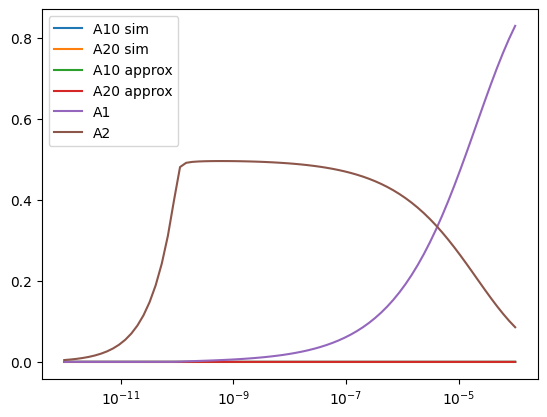

In [1861]:
plt.semilogx(A0s, A10_array/ftot_synapse, label='A10 sim')
plt.semilogx(A0s, A20_array/ftot_synapse, label = 'A20 sim')
plt.semilogx(A0s, A10_approx/ftot_synapse, label = 'A10 approx')
plt.semilogx(A0s, A20_approx/ftot_synapse, label = 'A20 approx')
plt.semilogx(A0s, A1_array/rtot, label = 'A1')
plt.semilogx(A0s, A2_array/rtot, label = 'A2')

plt.legend()

Text(0.5, 0, 'Antibody concentration')

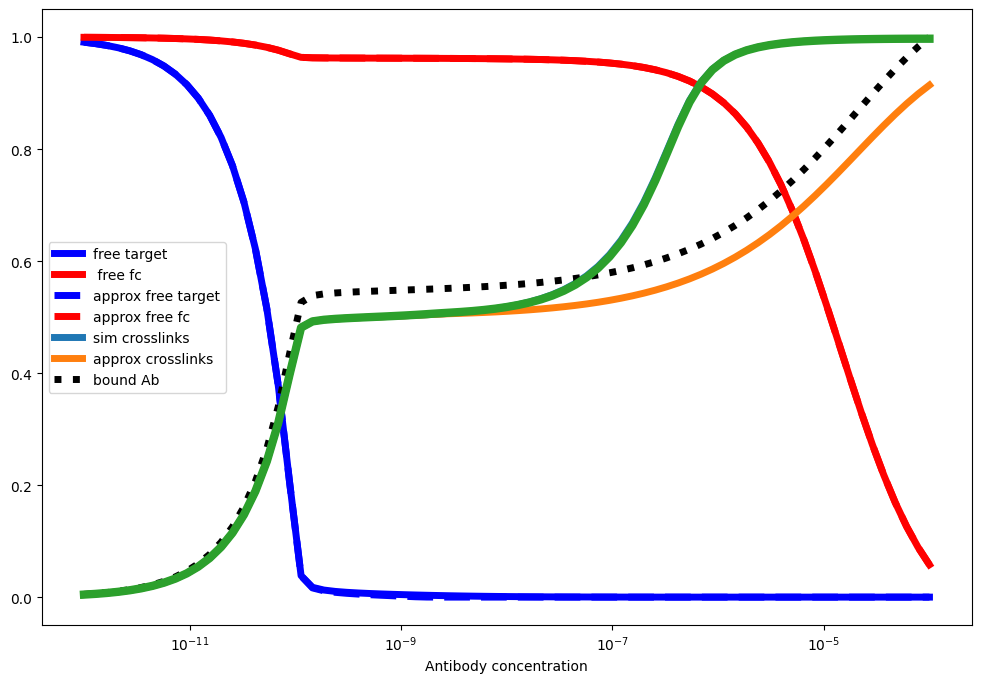

In [1862]:
fig, ax = plt.subplots(figsize=(12, 8))

div = np.min([rtot_synapse, ftot_synapse])
ax.semilogx(A0s, rt_array/rtot_synapse, label='free target',lw=5, color='blue')
ax.semilogx(A0s, rf_array/ftot_synapse, label=' free fc', lw=5, color='red')
ax.semilogx(A0s, rt_sim/rtot_synapse, label='approx free target', linestyle='dashed', lw=5, color='blue')
ax.semilogx(A0s, rf_sim/ftot_synapse, label='approx free fc', linestyle='dashed', lw=5, color='red')
ax.semilogx(A0s, fc_sim_array/div, label='sim crosslinks', lw=5)
ax.semilogx(A0s, fc_crosslinks/div, label = 'approx crosslinks', lw=5)
ax.semilogx(A0s, (A1_array + A2_array)/np.max(A1_array + A2_array), label = 'bound Ab', lw=5, color='black', linestyle='dotted')
ax.semilogx(A0s, crosslinks_guess/div, lw=6)
plt.legend()
plt.xlabel('Antibody concentration')

In [1863]:
print(rf_array)
print(rf_sim)

[165691.00642636 165675.1347562  165654.77698399 165628.66512897
 165595.17282641 165552.21403804 165497.11313856 165426.43829345
 165335.78776125 165219.5158353  165070.3814079  164879.09738779
 164633.75320184 164319.07520943 163915.48140503 163397.88036004
 162734.18018717 161883.68860928 160799.31172687 159763.17330059
 159625.02330518 159589.26654962 159569.29582997 159554.91671515
 159543.07043142 159532.41583889 159522.20230341 159511.91802008
 159501.14909292 159489.51043075 159476.60429189 159461.98953605
 159445.15387106 159425.48483902 159402.23658716 159374.48984773
 159341.10245567 159300.64734081 159251.33429919 159190.91098646
 159116.53747082 159024.62730973 158910.64644909 158768.85928569
 158592.00900363 158370.91691857 158093.98326098 157746.57008749
 157310.24666055 156761.88011247 156072.56181128 155206.37613891
 154119.04862582 152756.56165886 151053.90613868 148934.25361272
 146308.99080563 143079.24608999 139139.7116396  134385.63969774
 128723.72081442 122086.9